In [197]:
from astropy.io import fits,ascii
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy import constants, units as u
from astropy.wcs import WCS, utils as wcsutils
from astropy.coordinates import SkyCoord
import astropy.visualization as vis
from astropy.cosmology import Planck18

from pyqsofit.PyQSOFit import QSOFit

from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion
from regions import PixCoord

import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from os import path
import os
import ppxf.ppxf_util as util

from spectral_cube import SpectralCube

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
c = constants.c.to(u.km/u.s).value  # speed of light in km/s

def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None),**arg):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize,dpi=300)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if vmin is None:
        vmin = med
    if vmax is None:
        vmax = med + 10*std
    if norm is None:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap,**arg)
    if colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        # Append axes to the right of ax, with 2% width and no padding
        cax = divider.append_axes("right", size="10%", pad=0.0)
        cb=fig.colorbar(im, cax=cax)
        cb.set_label(cblabel)
    return fig, ax, im

## Read data cube and construct variance

In [45]:
multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="UGC"
psname2="2369"

instru="OSIRIS_K"
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]
RA=sentry["RA"].value#[43.507814008,43.507573386,43.50724857]
Dec=sentry["Dec"].value#[14.9700775,14.9708075,14.97041556]
datapath=os.path.join(multiAGNpath,psname1+psname2)
z = sentry["z_sys"][2]
path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')
sc = SkyCoord(RA,Dec,unit=u.deg)
cubefile = datapath+"/OSIRIS/UGC2369S_clean_swapped_fluxcal.fits"

In [15]:
#np.savetxt(datapath+"/OSIRIS/sigma_array.txt",sigma_array)

In [16]:
sigma_array=np.loadtxt(datapath+"/OSIRIS/sigma_array.txt")

In [17]:
chdu=fits.open(cubefile)

In [18]:
hdr=chdu[0].header
if "CDELT1" in hdr.keys():
    cdkey="CDELT"
    for nax in range(1,4):
        hdr[f"CD{nax}_{nax}"]=hdr[f"CDELT{nax}"]
    hdr["CD1_2"]=0
    hdr["CD2_1"]=0
    hdr["CD1_3"]=0
    hdr["CD3_1"]=0
    hdr["CD2_3"]=0
    hdr["CD3_2"]=0
data_hdu = fits.PrimaryHDU(data=s.cube*1e17,header=hdr)
#data_hdu.writeto(datapath+"/OSIRIS/datacube.fits",overwrite=True)

In [126]:
hdr=chdu[0].header
if "CDELT1" in hdr.keys():
    cdkey="CDELT"
else:
    cdkey="CD3_"
wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr[f'{cdkey}3'] + hdr['CRVAL3']

#sigma_array=np.empty(wc.shape)

#for i in range(wc.shape[0]):
#    mean, median, stddev = sigma_clipped_stats(chdu[0].data[i,:],sigma=3,maxiters=None)
#    sigma_array[i]=stddev


array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [20]:
var_hdu = fits.PrimaryHDU(data=s.varcube*1e34,header=hdr)
var_hdu.writeto(datapath+"/OSIRIS/varcube.fits",overwrite=True)

In [21]:
Sub_cube=SpectralCube.read(datapath+"/OSIRIS/datacube.fits")
Var_cube=SpectralCube.read(datapath+"/OSIRIS/varcube.fits")

## Extract H2 emissions with CubEx

In [22]:
lines={"Brd":[1945.09],"Brg":[2166.121],"H2_10_S1":[2121.8],"H2_10_S3":[1957.6],"H2_10_S2":[2033.8]\
       ,"H2_10_S0":[2223.5],"H2_21_S3":[2073.5],"H2_21_S1":[2247.7],"SiVI":[1964.0],"HeI":[2058.69]} #Angstroms, but for IR line it is micron

In [168]:
hdr["PSCALE"],hdr["CD1_1"]*3600

(0.1799, 0.10000008)

array([0.10000008, 0.10000008])

In [144]:
linename="H2_10_S1"
Checkcube=fits.open(datapath+f"/OSIRIS/checkcube_{linename}.fits")
objcat=np.genfromtxt(datapath+f"/OSIRIS/{field}_{linename}.cat")
mask_3d=Checkcube[0].data

wcsinfo=WCS(data_hdu.header).celestial
# wavelength range for the extraction cube
lw=Checkcube[0].header["CRVAL3"]
hw=Checkcube[0].header["CRVAL3"]+(mask_3d.shape[0]-1)*Checkcube[0].header["CD3_3"]

#Cut-off: geometric center of the detected object must be within N pixels of the PSF center (~4.5 arcsec)
Npix=50


#s_coord=wcsinfo.world_to_pixel(sc[2])
s_coord=[11,19]
if len(objcat.shape)>1:
    obj_coord=objcat[:,2:4]
    obj_num=objcat[:,0]
    dis=np.linalg.norm(obj_coord - np.array(s_coord),axis=1)
    print("distance from PSF to objects (pixels):")
    print(dis)
    sel_num=obj_num[dis<Npix]
    print("selected objects: obj_num, N_Voxels")
    print(sel_num,objcat[:,1][dis<Npix])
else:
    sel_num=objcat[0]
    obj_coord=objcat[2:4]

#sel_num=np.array([4])
mask_3d_filtered=np.isin(mask_3d, sel_num.astype(int))

'''
region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)
rmask=region_pix4.to_mask()
rmask2D_image = rmask.to_image(mask_3d_filtered.shape[1:])
expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)

mask_3d_filtered=mask_3d_filtered & (~expanded_rmask_image.astype(bool))
'''


subcube1=Sub_cube.spectral_slab(lw*u.nm,hw*u.nm)
subcube2=subcube1.unmasked_data[:].value

specwidth=0.25*10 #0.25 nm to 2.5 AA

# Extract the spaxels that are marked as detection in CubEx
line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, np.nan)
line_maskedvarcube = np.where(mask_3d_filtered.astype(bool), Var_cube.spectral_slab(lw*u.nm,hw*u.nm).unmasked_data[:].value, np.nan)

line_mflux=np.nansum(line_maskedcube,axis=0)*specwidth

# Constructing 2D-mask inorder to extract the 1-D spectrum in the Lya Nebulosity 
mask_2d_filtered=np.nansum(mask_3d_filtered,axis=0)
expanded_mask = np.repeat(mask_2d_filtered[np.newaxis, :, :], Sub_cube.shape[0], axis=0)

# 2D mask criteria: line flux larger than .125 * 1e-16
#masked_2d_peak = line_mflux > 10
#masked_2d_peak = mask_ratio_array
newmask=mask_2d_filtered.astype(bool) #& masked_2d_peak
#newmask[int(ypix)+1:,:]=False
#newmask[:,int(xpix):]=False
expanded_mask_peak = np.repeat(newmask[np.newaxis, :, :], Sub_cube.shape[0], axis=0)

# reconstruct a new cube for velocity dispersion, velocity shift calculations.
#mask = mask_3d_filtered.astype(bool)
new_cube = SpectralCube(data=line_maskedcube, wcs=subcube1.wcs)

line_shift_lambda=new_cube.moment(order=1)

line_widthsigma=new_cube.linewidth_fwhm()

line_w_mean=np.mean(lines[linename])
line_shift_velocity=(line_shift_lambda.to(u.nm).value/(1+z)-line_w_mean)/line_w_mean*constants.c.to(u.km/u.s).value
line_widthsigma_velocity=line_widthsigma.to(u.nm).value/line_w_mean*constants.c.to(u.km/u.s).value/(1+z)

#Plume_cube=Sub_cube.subcube_from_mask(expanded_mask.astype(bool))
Plume_cube=np.where(expanded_mask.astype(bool), data_hdu.data, 0)
#Plume_varcube=Var_cube.subcube_from_mask(expanded_mask.astype(bool))
Plume_varcube=np.where(expanded_mask.astype(bool), var_hdu.data, 0)

Peak_cube=np.where(expanded_mask_peak, data_hdu.data, 0)
Peak_varcube=np.where(expanded_mask_peak, var_hdu.data, 0)
#Peak_varcube=Var_cube.subcube_from_mask(expanded_mask_peak)

#Full_cube=np.where(expanded_mask_peak, Org_cube.unmasked_data[:].value, 0)
pix_scale=wcsinfo.pixel_scale_matrix[1,1]*3600


var1=np.nansum(Peak_varcube,axis=(1,2))
spec1=np.nansum(Peak_cube,axis=(1,2))
var=np.nansum(Plume_varcube,axis=(1,2))
spec=np.nansum(Plume_cube,axis=(1,2))

#Org_spec=np.nansum(Full_cube,axis=(1,2))*pix_scale**2

distance from PSF to objects (pixels):
[ 0.60008333 27.75592189 32.07900404  9.82344135 32.55036252]
selected objects: obj_num, N_Voxels
[1. 2. 3. 4. 5.] [4.551e+03 1.169e+03 4.000e+00 4.000e+00 1.300e+01]


(1904.8080651415275, 2308.065141527724)

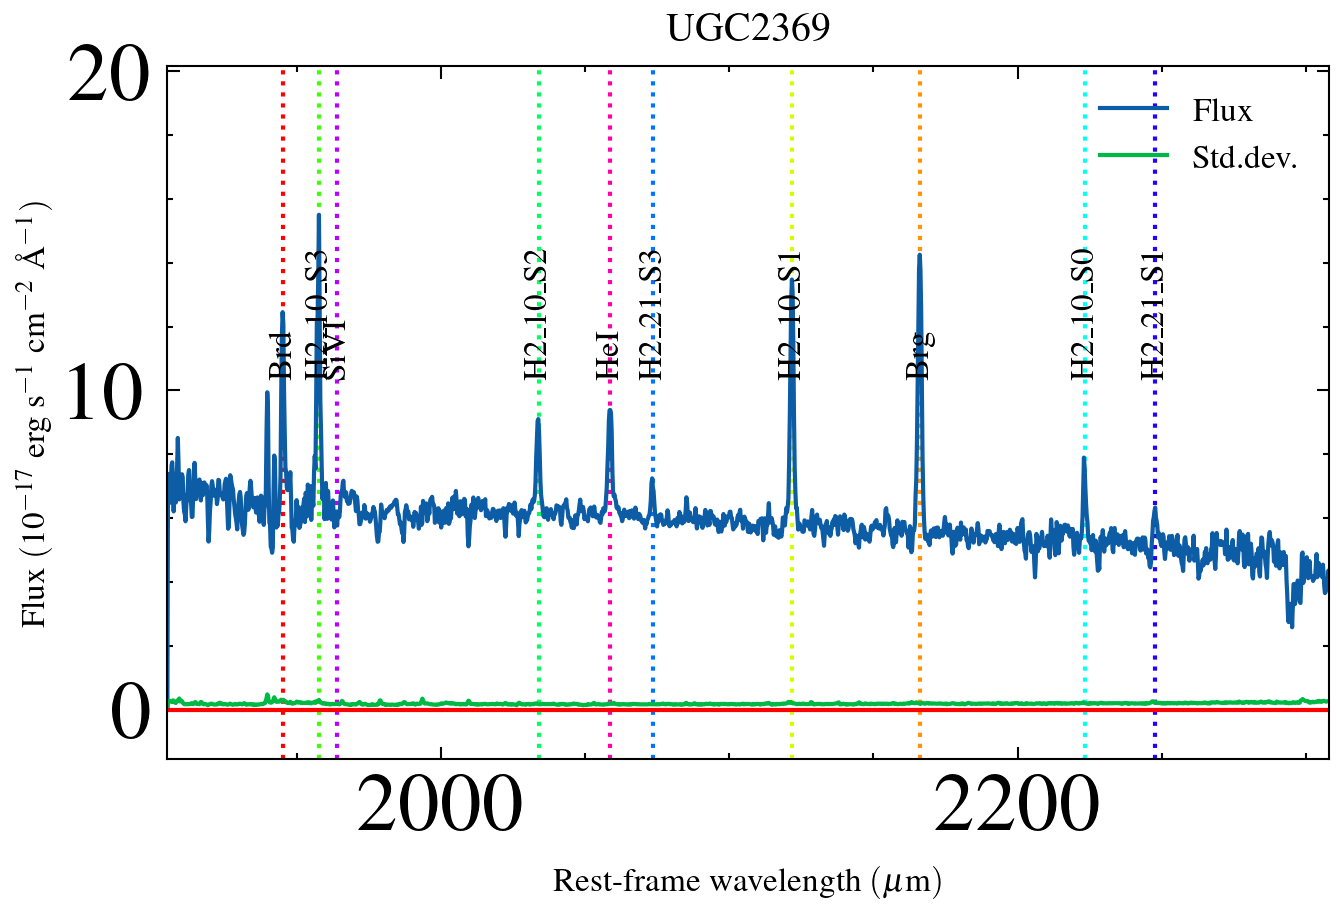

In [569]:
### ============================1D spectrum from detected Lya nebulosity========================================================================
import scienceplots
import matplotlib
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

rng1 = np.random.default_rng(122807528840384100672342137672332424406)
regu = r"Flux $\rm (10^{-17}~erg~s^{-1}~cm^{-2}~\AA^{-1})$"
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

x = wc
xlow= wc[0]/(1+z)
#xlow=2100
#xhigh=2180
xhigh=wc[-1]/(1+z)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))


# redshift of the CGM being probed. QSO sight-line
zcgm = z
rlinec= (zcgm+1)/(z+1)
mask=np.full(len(x),False)

yup=np.max(spec1[~mask][:1000])
#yup=np.max(Org_spec[~mask][:1000])
plt.ylim(-yup*1e-1, yup*1.3)
#Marking the important lines
#ax.axvline(rlinec*1215.67,ls=":")
#ax.text(rlinec*1215.67, yup/1.3,r"Ly$\alpha$",rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=10)
dlam=7.5/2800


#xlow=1500
#xhigh=1580
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(rlinec*line,ls=":",c=colors[ind])
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
        # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(rlinec*line, yup/1.5,key,rotation=90,verticalalignment='bottom',horizontalalignment='center')

#ax.plot(x[~mask]/(1+redshift), Org_spec[~mask], label = "Continuum subtracted cube")

ax.plot(x[~mask]/(1+z), spec1[~mask],"-", label = "Flux")
#ax.plot(x[~mask]/(1+redshift), spec1[~mask],"b:", label = "Flux from peak")
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax.plot(x[~mask]/(1+z), np.sqrt(var1[~mask]), label = "Std.dev.")
ax.axhline(0,color="r")
ax.legend(loc="best")
ax.set_xlabel(r"Rest-frame wavelength $(\rm \mu m)$")
ax.set_ylabel(regu)
ax.set_title("{}".format(field))
ax.set_xlim([xlow,xhigh])

#fig.savefig(KBSSpath+"/QSOs/{}neb_{}-{}_1d.pdf".format(linename,field,sname))



Text(0.5, 1.0, 'SB profile for H2_10_S1 (z=0.03)')

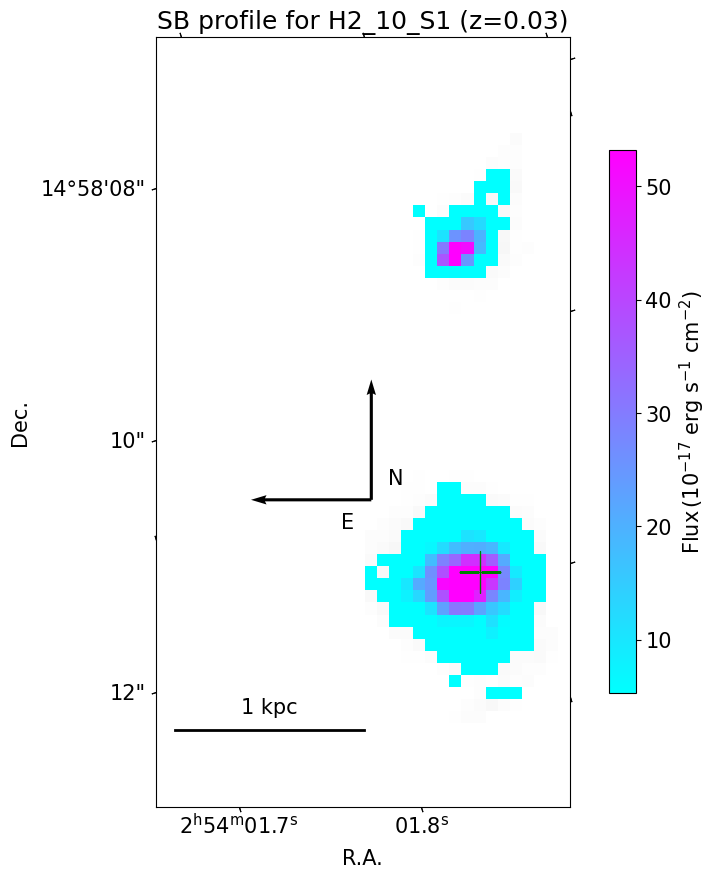

In [48]:
### ============================2D SB profile========================================================================
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"Flux$\,\rm (10^{-17}~erg~s^{-1}~cm^{-2})$"

efactor=1
Lya_mflux=np.nansum(Sub_cube.spectral_slab(lw*u.nm,hw*u.nm).unmasked_data[:],axis=0)*efactor


#mask=Lya_mflux.value < std*0.07
#mask=Lya_mflux.value < 2.5*Lya_msig.value
#plotmom1=Lya_moment_1.copy()
#plotmom1[mask]=np.nan
# Integrated Lya image
#std=np.std(Lya_mflux.value)

fig, ax, im1 = imshow_astro(Lya_mflux, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (std*0.01, 50*std),cmap = "binary")
#im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
#vmin=-400
#vmax=400

#im = ax.contour(NB,levels=[1,3,5,8,10,20])
#im = ax.imshow(plotmom1.value,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
masked_data = np.ma.masked_where(line_mflux == 0, line_mflux)
#masked_data = np.ma.masked_where(~newmask, line_mflux)
_, med, std = sigma_clipped_stats(masked_data*efactor)
im = ax.imshow(masked_data*efactor,cmap=cmap,alpha=alpha,vmin=std,vmax=10*std)#,norm=norm)

#cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
cb = plt.colorbar(im, label = Lyau, fraction =0.035)
#Source position
#psname=sourcename


#sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame="icrs", equinox='J2000')
#s_coord=wcsinfo.world_to_pixel(sc)

#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)


ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
#ax.plot(68.5,34.39,"+",c="g",ms=30,lw=0.1)
#ax.text(s_coord[0]-2,s_coord[1]-8
#        ,"{}".format(sname),color="green",verticalalignment='bottom',horizontalalignment='right')


#ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)



x0, y0 = 2, 25
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)
from regions import RectangleSkyRegion,CirclePixelRegion
from regions import PixCoord
#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
#region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
#region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#plt.imshow(rmask_image, cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower')

#-------------------Reference scale setting----------------#
dT = 1  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(z).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel


delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')

ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"SB profile for {} (z={})".format(linename,round(z,2)))
#fig.savefig(datapath+"/SB_{}.pdf".format(linename))

## Calculating total hydrogen mass and hydrogen column density NH

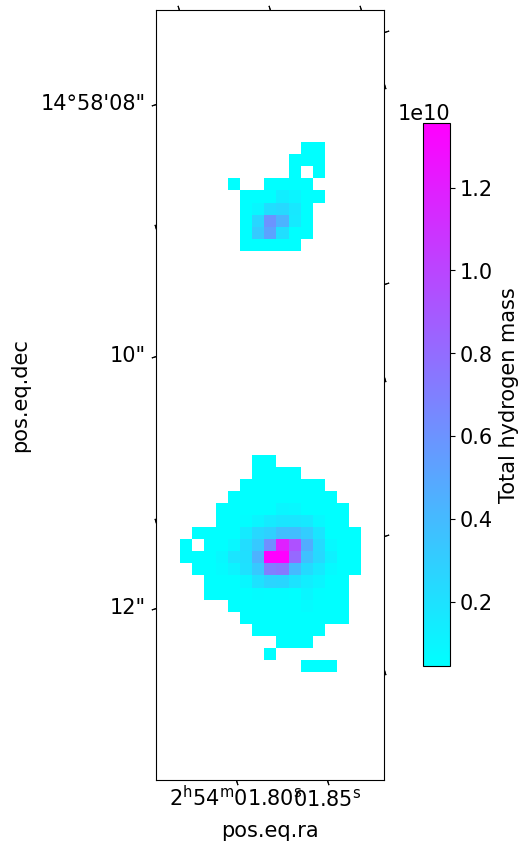

In [54]:
from dust_attenuation.averages import C00
Cex=C00()
#wave=[0.4821,0.5009,0.6563,2.12,2.2,]
EBV=3.1540189184745593
#hot2cold=7e-5
hot2cold=1/0.3e6 # Mazzalay+2013, aa37092-19
ld=Planck18.luminosity_distance(0.03145)
A22=Cex.k_lambda(x=[2.199])*EBV
MH2=5.1e13*(ld.to(u.Mpc).value)**2*(masked_data*efactor*1e-17)*10**(0.4*A22)/hot2cold # cold H2 mass; Scoville+1982, Wolniewicz+1998
logMHG=np.log10(MH2)+0.92
MH=10**logMHG+MH2
_, med, std = sigma_clipped_stats(MH)

fig, ax, im1 = imshow_astro(MH, wcsinfo, cblabel = r"Total hydrogen mass", colorbar=True,stretch=vis.LinearStretch(), vrange = (std, 30*std),cmap = "cool")



In [51]:
1/7e-5

14285.714285714286

In [50]:
ld.to(u.Mpc).value

142.90403676577586

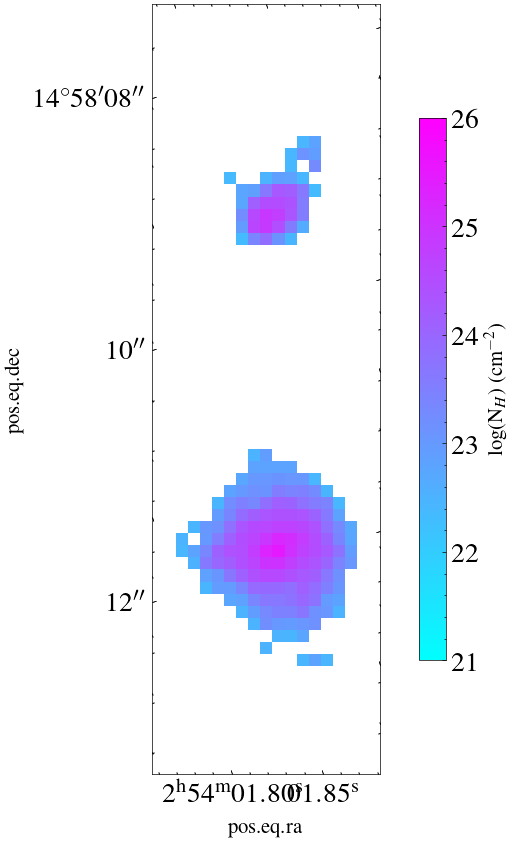

In [676]:
pdis=Planck18.kpc_proper_per_arcmin(0.0315).to(u.cm/u.arcsec)
parea=(pixsize*u.arcsec*pdis)**2
NH_mol=constants.M_sun.to(u.g)*MH2/(2.01568*u.g/u.mole)*constants.N_A/parea*2

NH = np.log10((constants.M_sun.to(u.g)*10**logMHG/(1.00784*u.g/u.mole)*constants.N_A/parea+NH_mol).value)

NH[NH<21]=np.nan
_, med, std = sigma_clipped_stats(NH)

fig, ax, im1 = imshow_astro(NH, wcsinfo, cblabel = r"log(N$_{H}$) (cm$^{-2}$)", colorbar=True,stretch=vis.LinearStretch(), vrange = (21, 26),cmap = "cool")


In [318]:
0.662

0.662

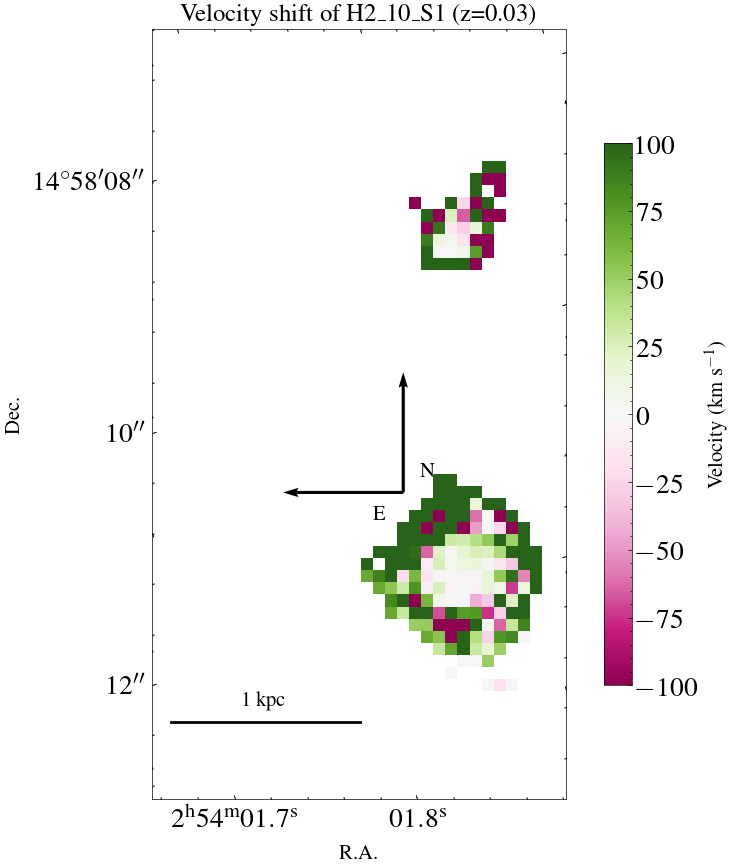

In [634]:
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux)
#mask=Lya_mflux < 2.*Lya_msig.value
plotlw=line_shift_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (0, 20*std),cmap = "binary")
im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=1
vmin=-100
vmax=100

im = ax.imshow(plotlw,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

cb = plt.colorbar(im, label = r"Velocity ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
#psname=sourcename


#for i in range(3):
#    sc = SkyCoord(ra=RA[i], dec=Dec[i], unit='deg',frame="icrs", equinox='J2000')
#    s_coord=wcsinfo.world_to_pixel(sc)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)



x0, y0 = 5, 25
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)


#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
#region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
#region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#-------------------Reference scale setting----------------#
dT = 1  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(z).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"Velocity shift of {} (z={})".format(linename,round(z,2)))
fig.savefig(datapath+"/vshift_{}.pdf".format(linename))

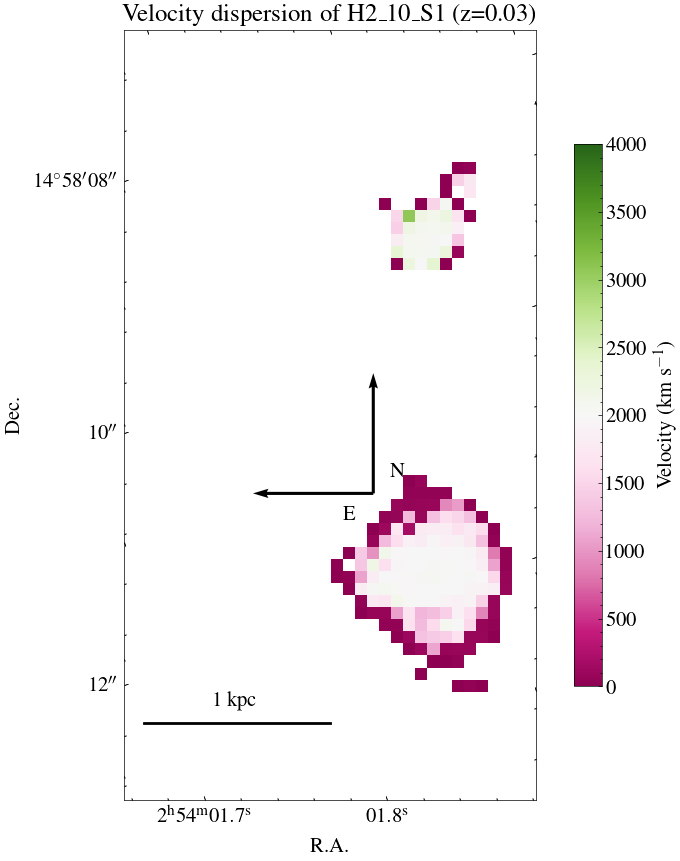

In [489]:
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux)
#mask=Lya_mflux < 2.*Lya_msig.value
plotlw=line_widthsigma_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (0, 20*std),cmap = "binary")
im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
alpha=1
vmin=0
vmax=4000

im = ax.imshow(plotlw,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

cb = plt.colorbar(im, label = r"Velocity ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
#psname=sourcename


#for i in range(3):
#    sc = SkyCoord(ra=RA[i], dec=Dec[i], unit='deg',frame="icrs", equinox='J2000')
#    s_coord=wcsinfo.world_to_pixel(sc)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)



x0, y0 = 5, 25
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)


#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
#region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
#region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#-------------------Reference scale setting----------------#
dT = 1  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(z).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"Velocity dispersion of {} (z={})".format(linename,round(z,2)))
fig.savefig(datapath+"/sigma_{}.pdf".format(linename))

In [337]:
s_coord

(array(12.77946458), array(14.23381618))

In [295]:
np.nanmax(plotlw)

2703147.421419709

## Setup parameter table

In [553]:

# create FITS file containing fitting parameter setup 
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    #(21661.21, 'Brg', 19400, 23000, 'Brg_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (19450.9, 'Brg', 19400, 23000, 'Brd_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (21661.21, 'Brg', 19400, 23000, 'Brg_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (19576.00, 'Brg', 19400, 23000, 'H2_10_S3', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (20338.00, 'Brg', 19400, 23000, 'H2_10_S2', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (21218.00, 'Brg', 19400, 23000, 'H2_10_S1', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (22235.00, 'Brg', 19400, 23000, 'H2_10_S0', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (22477.00, 'Brg', 19400, 23000, 'H2_21_S1', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (20735.00, 'Brg', 19400, 23000, 'H2_21_S3', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    #(19640.21, 'Brg', 21000, 22100, 'SiVI_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 2, 0, 0, 0.05, 1),
    (19640.00, 'Brg', 19400, 23000, 'SiVI', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    (20586.90, 'Brg', 19400, 23000, 'HeI', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 2, 0, 0.002, 1),
    #(19640.00, 'Brg', 19500, 22000, 'SiVI_w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-6, 0.00169, 0.01, 0, 0, 0, 0.002, 1)
    
    #(21661.21, 'Brg', 21000, 22100, 'Brg_naw', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-6, 0.00169, 5e-3, 0, 0, 0, 0.001, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    (19700.,20250.),
    (21700.,22250.)
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000,20000,20900]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_field_{}.fits'.format(instru)), overwrite=True)

In [549]:
Table(line_priors)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
21661.21,Brg,19400.0,23000.0,Brg_br,2,0.0,0.0,10000000000.0,0.005,0.0004,0.05,0.015,0,0,0,0.05,1
19450.9,Brd,19400.0,23000.0,Brd_na,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,1,0,0.002,1
21661.21,Brg,19400.0,23000.0,Brg_na,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,1,0,0.002,1
19576.0,Brg,19400.0,23000.0,H2_10_S3,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1
20338.0,Brg,19400.0,23000.0,H2_10_S2,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1
21218.0,Brg,19400.0,23000.0,H2_10_S1,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1
22235.0,Brg,19400.0,23000.0,H2_10_S0,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1
22477.0,Brg,19400.0,23000.0,H2_21_S1,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1
20735.0,Brg,19400.0,23000.0,H2_21_S3,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,0.01,1,2,0,0.002,1


## Perform voronoi binning

In [9]:

class read_osiris_cube(object):
    def __init__(self, filename,redshift , wave_range=None,mask=None):
        """
        Read cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62Å. Range: 2.51--2.88 (ESO instrument manual)
        
        """
        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   # cube.shape = (3681, nx, ny)
        varcube = sigma_array[:,np.newaxis,np.newaxis]**2*np.ones(hdu[0].data.shape)
   #     sigma =
        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra_org = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        sigma_org = np.sqrt(varcube.reshape(npix, -1))
        #wave = head['CRVAL3'] + head['CDELT3']*np.arange(npix)
        wave = (np.arange(head['NAXIS3']) - head['CRPIX3'] + 1) * head['CDELT3'] + head['CRVAL3']
        pixsize = abs(head["CDELT1"])*3600    # pixel scale

        # Only use a restricted wavelength range
        if wave_range is not None:
            w = (wave > wave_range[0]) & (wave < wave_range[1])
            spectra_org = spectra_org[w, :]
            sigma_org = sigma_org[w, :]
            wave = wave[w]
        elif mask is not None:
            spectra_org = spectra_org[mask, :]
            sigma_org = sigma_org[mask, :]
            wave = wave[mask]

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra_org, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        #x = col
        #y = row
        velscale = c*np.diff(np.log(wave[-2:]))  # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra_org, velscale=velscale)
        
        self.cube=cube
        self.varcube=varcube
        self.pixelsize = pixsize
        self.spectra = spectra
        self.spectra_org = spectra_org
        self.sigma_org = sigma_org
        self.wave = wave
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.redshift = redshift
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

In [10]:
s=read_osiris_cube(cubefile,0.0316)

In [331]:
cut1=1075
cut2=1084
line_masked_cube_reshaped = line_maskedcube.reshape(line_maskedcube.shape[0],-1)
line_masked_varcube_reshaped = line_maskedvarcube.reshape(line_maskedcube.shape[0],-1)
#signal=np.nansum(s.spectra_org[cut1:cut2,:],axis=0)
signal = np.nansum(line_masked_cube_reshaped,axis=0)
#signal[signal==0]=np.nan
sigma_tot = np.sqrt(np.nansum(line_masked_varcube_reshaped,axis=0))

In [332]:
sigma_tot[sigma_tot == 0]=0.2
sigma_tot[sigma_tot == np.nan]=0.2


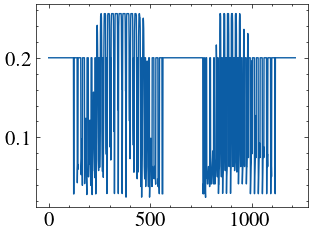

In [333]:
plt.plot(sigma_tot)

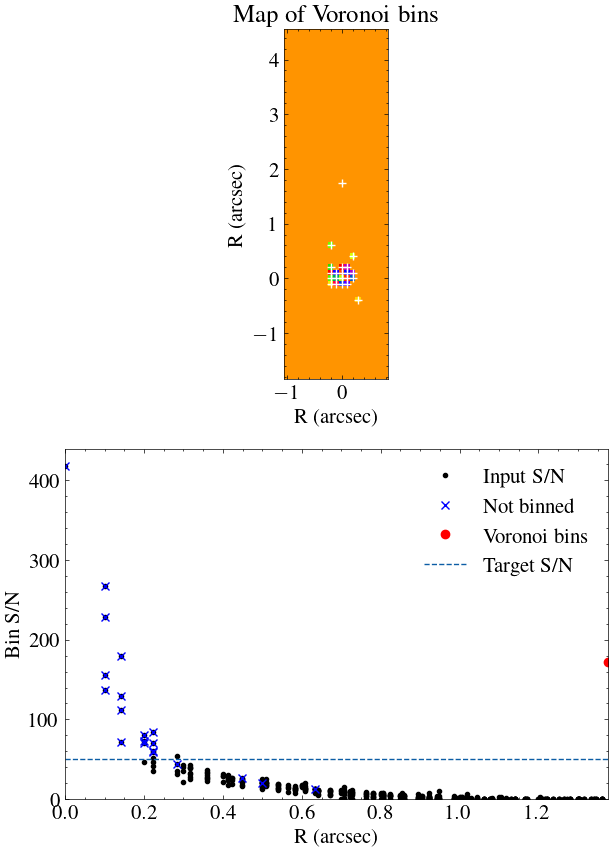

In [ ]:
plt.figure(figsize=(7,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(s.x, s.y, signal, sigma_tot, 50,pixelsize=pixsize, plot=1, quiet=1)

## Pixel-wise fitting on the region with Br_delta degection
Voronoi binning behaves very badly

### Star fitting

In [26]:
path_out=datapath+"/field_scan_osiris"
#nbins=3
#tbin=44
sshape=s.cube.shape[1:]
qlist=[[[] for _ in range(sshape[1])] for _ in range(sshape[0])]
for i in range(sshape[0]):
    for j in range(sshape[1]):
        if mask_2d_filtered[i,j]:
            flux = s.cube[:,i,j]*1e17
            err = np.sqrt(s.varcube[:,i,j])*1e17
            #mask= (flux>0.0001)# & mask0
            q_temp = QSOFit(s.wave*10, flux, err, s.redshift, path=path_ex)

            q_temp.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
                  # prepocessing parameters
                  nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
                  and_mask=False,  # delete the and masked pixels
                  or_mask=False,  # delete the or masked pixels
                  reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
                  deredden=True,  # correct the Galactic extinction
                  wave_range=None,  # trim input wavelength
                  wave_mask=None,  # 2-D array, mask the given range(s)

                  # host decomposition parameters
                  decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
                  host_prior=False, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
                  host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

                  host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
                  decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
                  qso_type='CZBIN1', # PCA template name for quasar
                  npca_qso=10, # numebr of quasar templates
                  host_type='PCA', # template name for galaxy
                  npca_gal=5, # number of galaxy templates

                  # continuum model fit parameters
                  Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
                  poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
                  BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
                  initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
                  rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
                  n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

                  # emission line fit parameters
                  linefit=True,  # If True, the emission line will be fitted
                  rej_abs_line=False,
                  # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

                  # fitting method selection
                  MC=False,
                  # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
                  MCMC=False,
                  # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
                  nsamp=200,
                  # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

                  # advanced fitting parameters
                  param_file_name='qsopar_field_OSIRIS_K.fits',  # Name of the qso fitting parameter FITS file.
                  nburn=20,  # The number of burn-in samples to run MCMC chain
                  nthin=10,  # To set the MCMC chain returns every n samples
                  epsilon_jitter=0.,
                  # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

                  # customize the results
                  save_result=False,  # If True, all the fitting results will be saved to a fits file
                  save_fits_name=None,  # The output name of the result fits
                  save_fits_path=path_out,  # The output path of the result fits
                  plot_fig=False,  # If True, the fitting results will be plotted
                  save_fig=False,  # If True, the figure will be saved
                  plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True

                  # debugging mode
                  verbose=False,  # turn on (True) or off (False) debugging output

                  # sublevel parameters for figure plot and emcee
                  kwargs_plot={
                      'save_fig_path': '.',  # The output path of the figure
                      'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
                  },
                  kwargs_conti_emcee={},
                  kwargs_line_emcee={})
            #np.exp(s.ln_lam_gal)
         #   goodpixels0=np.flatnonzero(mask)
        #    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start,goodpixels0, lam_gal, sps.lam_temp)
            plt.close()
            qlist[i][j]=q_temp
    #optimal_templates[:, j] = bestfit_template

    #light_weights = pp.weights.reshape(reg_dim)
    #lg_age_bin[j], metalbin[j] = sps.mean_age_metal(light_weights)

            print(f"Bin row, col: {i},{j}")
            #plt.title(f"Bin row, col: {i},{j}")

Bin row, col: 9,12
Bin row, col: 9,13
Bin row, col: 9,14
Bin row, col: 10,9
Bin row, col: 11,10
Bin row, col: 11,11
Bin row, col: 11,12
Bin row, col: 12,8
Bin row, col: 12,9
Bin row, col: 12,10
Bin row, col: 12,11
Bin row, col: 12,12
Bin row, col: 12,13
Bin row, col: 13,7
Bin row, col: 13,8
Bin row, col: 13,9
Bin row, col: 13,10
Bin row, col: 13,11
Bin row, col: 13,12
Bin row, col: 13,13
Bin row, col: 13,14
Bin row, col: 13,15
Bin row, col: 14,6
Bin row, col: 14,7
Bin row, col: 14,8
Bin row, col: 14,9
Bin row, col: 14,10
Bin row, col: 14,11
Bin row, col: 14,12
Bin row, col: 14,13
Bin row, col: 14,14
Bin row, col: 14,15
Bin row, col: 15,4
Bin row, col: 15,5
Bin row, col: 15,6
Bin row, col: 15,7
Bin row, col: 15,8
Bin row, col: 15,9
Bin row, col: 15,10
Bin row, col: 15,11
Bin row, col: 15,12
Bin row, col: 15,13
Bin row, col: 15,14
Bin row, col: 15,15
Bin row, col: 16,4
Bin row, col: 16,5
Bin row, col: 16,6
Bin row, col: 16,7
Bin row, col: 16,8
Bin row, col: 16,9
Bin row, col: 16,10
Bin r

In [27]:
ln_to_print=['H2_10_S0','H2_10_S1','H2_10_S2','H2_10_S3','H2_21_S1','H2_21_S3','HeI','Brg_na','Brd_na']

In [28]:
all_area=[[[] for _ in range(sshape[1])] for _ in range(sshape[0])]
all_peaks=[[[] for _ in range(sshape[1])] for _ in range(sshape[0])]
all_fwhms=[[[] for _ in range(sshape[1])] for _ in range(sshape[0])]
all_snrs=[[[] for _ in range(sshape[1])] for _ in range(sshape[0])]
plot=False
for i in range(sshape[0]):
    for j in range(sshape[1]):
        if mask_2d_filtered[i,j]:
            q=qlist[i][j]
            if plot:
                fig, axs = plt.subplots(1, 2,figsize=(8,4), dpi=300)
                plt.subplots_adjust(wspace=0.5)
                ax=axs[0]
            #q=q_mle

            #q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)

            if q.MCMC:
                gauss_result = q.gauss_result[::2]
            else:
                gauss_result = q.gauss_result
            #plt.subplot(111)
            
            # Plot individual line components
            for p in range(int(len(gauss_result) / 3)):
                if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
                    color = 'g'  # narrow
                else:
                    color = 'r'  # broad
                if plot:
                    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)
            if plot:
                # Plot total line model
                ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
                ax.step(q.wave, q.line_flux, 'k',lw=0.5)
                yup=np.max(q.line_flux)
                #ax.step(q.wave,q.err)
                ax.set_xlim(19000, 23000)
                ax.set_ylim(1e-2, yup)
            areas={}
            peaks={}
            fwhms={}
            snrs={}
            for ind,ln in enumerate(ln_to_print):
                try:
                    fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'narrow')
                except:
                    snr=0
                if snr > 0.1:
                    areas[ln]=area
                    fwhms[ln]=fwhm
                    peaks[ln]=peak
                    snrs[ln]=snr
                else:
                    areas[ln]=None
                    fwhms[ln]=None
                    peaks[ln]=peak
                    snrs[ln]=snr
                if plot:
                    ax.axvline(peak,color="C{}".format(ind),lw=0.5,ls=":")
                    ax.text(peak*0.9975, 5e-1*yup,ln, rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
            all_area[i][j]=areas.copy()
            all_peaks[i][j]=peaks.copy()
            all_fwhms[i][j]=fwhms.copy()
            all_snrs[i][j]=snrs.copy()
            #ax.set_yscale("log")
            if plot:
                ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
                ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)
            #plt.subplot(122)
            #
                ax=axs[1]
                #mag=-2.5*np.log10(signal/np.sum(signal).ravel())
                #levels=[8,9,10,13,15,18,20,25,30,35,40]
                #img=display_bins(s.x, s.y, bin_num, np.array(line_properties[line+"_vpec"]),vmin=-100,vmax=350 ,cmap="viridis",colorbar=1,pixelsize=s.pixelsize, label=r'$V_{shift}$ (km/s)')
                img = ax.imshow(masked_data,cmap=cmap,alpha=alpha,vmin=std,vmax=30*std)#,norm=norm)

                #ax=plt.gca()
                ax.set_xlabel(r"x pix")
                ax.set_ylabel(r"y pix")
                #RApix=[3.4,4.4,5.3]
                #Decpix=[1.8,4.4,3.]
                #for io in range(3):
                #    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
                #ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
                ax.text(0.05,0.9,"Flux map",color="k",transform=ax.transAxes)
                ax.plot(j, i,"+",c="b",ms=10,lw=0.01)
                fig.savefig(datapath+f"/field_scan_osiris/bin_{i}_{j}.pdf")
                plt.close()


### Read and arrange results

In [295]:
#ratio_to_test=["H2_10_S1","Brg_na"]
ratio_to_test=["Brg_na","Brd_na"]
ratio_array=np.empty(sshape)
for i in range(sshape[0]):
    for j in range(sshape[1]):
        if mask_2d_filtered[i,j]:
            areas=all_area[i][j]
            peaks=all_peaks[i][j]
            if (areas[ratio_to_test[0]] is None) and (areas[ratio_to_test[1]] is None):
                ratio_array[i,j]=np.nan
            elif areas[ratio_to_test[0]] is None:
                sind=np.argmin(s.wave-peaks[ratio_to_test[0]])
                ratio_array[i,j]=np.sqrt(s.varcube[sind,i,j])*1e17/areas[ratio_to_test[1]]
            elif areas[ratio_to_test[1]] is None:
                sind=np.argmin(s.wave-peaks[ratio_to_test[1]])
                ratio_array[i,j]=areas[ratio_to_test[0]]/np.sqrt(s.varcube[sind,i,j])/1e17
            else:
                ratio_array[i,j]=areas[ratio_to_test[0]]/areas[ratio_to_test[1]]
                
        else:
            ratio_array[i,j]=np.nan

In [269]:
ratio_array.shape

(64, 19)

In [43]:
line="Brg_na"
line_value_array=np.empty(sshape)
for i in range(sshape[0]):
    for j in range(sshape[1]):
        snrs=all_snrs[i][j]
        if (mask_2d_filtered[i,j]) and (snrs[line] > 0.5):
            fwhms=all_fwhms[i][j]
            line_value_array[i,j]=fwhms[line]
        else:
            line_value_array[i,j]=np.nan

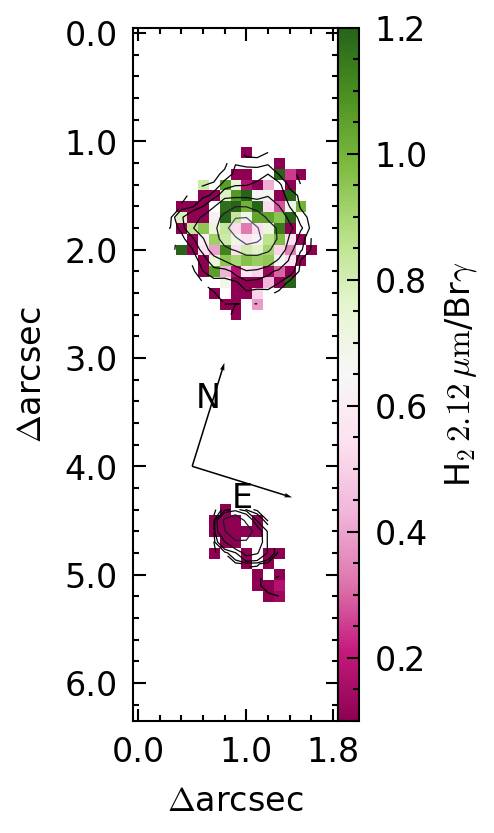

In [288]:
##  NIR AGN line ratio
    
    
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})



pixscale=wcsinfo.wcs.cdelt[0]*3600
xmax=ratio_array.shape[1]
ymax=ratio_array.shape[0]

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
Az=Cex.k_lambda(x=[2.12])-Cex.k_lambda(x=[2.1661])


z_toplot=ratio_array*10**Az#np.log10(ratio_array.copy()/1.4)*2.5/(0.43-0.36)

fig, ax, im1 = imshow_astro(z_toplot, cblabel = r"H$_{2}\,2.12\rm\,\mu m$/Br$\gamma$", colorbar=True,stretch=vis.LinearStretch(),figsize=(2,3), vrange = (0.1, 1.2),cmap = "PiYG")
                            #,extent=[-xmax*pix_scale/2, xmax*pix_scale/2, -ymax*pix_scale/2, ymax*pix_scale/2] )
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")

ax.contour(masked_data*efactor,linewidths=0.3,cmap="bone",levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))


x0, y0 = 5, 40
arrow_length = 1/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra + arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax.quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='k', ha='center', va='bottom')

# Plot the East arrow
ax.quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + east_vector[0]/2, y0 + east_vector[1]/2, 'E', color='k', ha='center', va='top')
#ax.text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")
yticks=np.array([0,10,20,30,40,50,60])
xticks=np.array([0,10,18])
ax.set_yticks(yticks)
ax.set_yticklabels(yticks*0.1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*0.1)
fig.savefig(datapath+"/fig/NIR_diagnostic_map.pdf")


#fig.savefig(datapath+f"/field_scan_osiris/ratiomap_{ratio_to_test[0]}_{ratio_to_test[1]}.pdf")

In [287]:
10**Az

array([1.06600981])

Text(0.5, 1.0, 'Line ratio Map (z=0.03)')

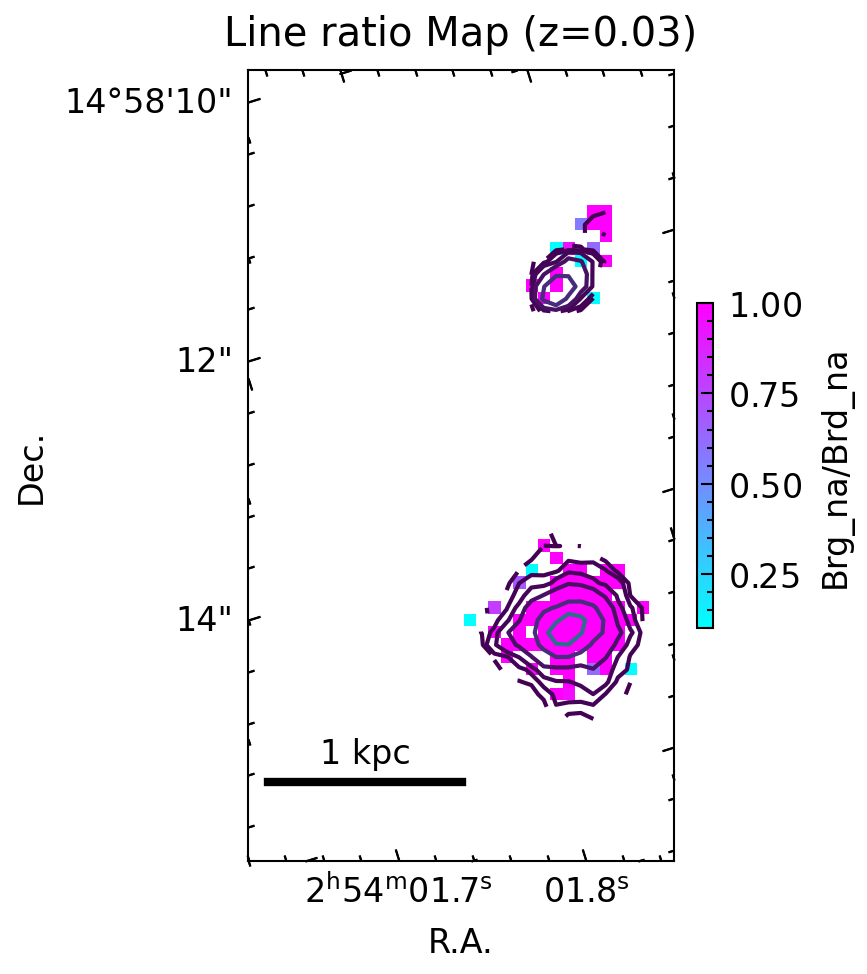

In [298]:
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux)
#mask=Lya_mflux < 2.*Lya_msig.value
#plotlw=line_shift_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux, wcsinfo, cblabel = Lyau,figsize=(2,4), colorbar=False, vrange = (0, 20*std),cmap = "binary")
im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
vmin=0.1
vmax=1.0
plotlw=ratio_array.copy()
#plotlw[~mask_ratio_array]=np.nan
im = ax.imshow(plotlw,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

ax.contour(masked_data*efactor,levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))

cb = plt.colorbar(im, label = f"{ratio_to_test[0]}/{ratio_to_test[1]}", fraction =0.035)

#Source position
#psname=sourcename


#for i in range(3):
#    sc = SkyCoord(ra=RA[i], dec=Dec[i], unit='deg',frame="icrs", equinox='J2000')
#    s_coord=wcsinfo.world_to_pixel(sc)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)


#-------------------Reference scale setting----------------#
dT = 1  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(z).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")
#ax.scatter(11,19)
mask_ratio_array=ratio_array>0.6
ax.set_title(r"Line ratio Map (z={})".format(round(z,2)))
#fig.savefig(datapath+f"/field_scan_osiris/ratiomap_{ratio_to_test[0]}_{ratio_to_test[1]}.pdf")

[Text(0, 0, '0.0'), Text(10, 0, '1.0'), Text(18, 0, '1.8')]

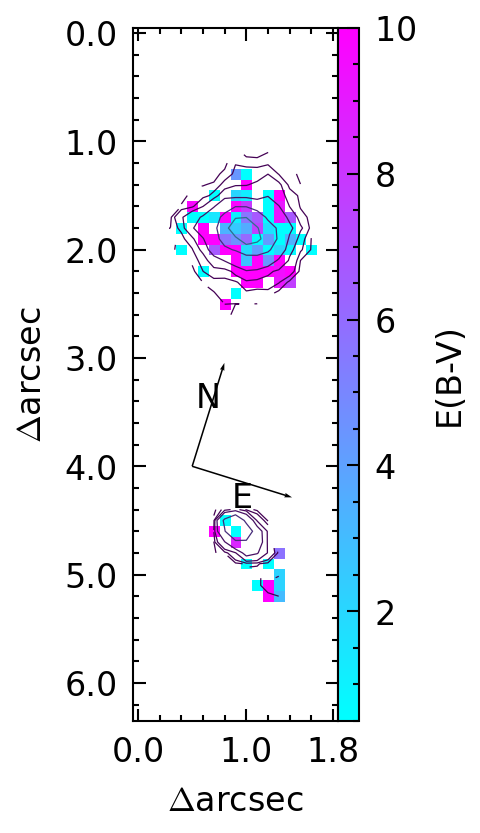

In [300]:
 plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})



pixscale=wcsinfo.wcs.cdelt[0]*3600
xmax=ratio_array.shape[1]
ymax=ratio_array.shape[0]

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
EBV_map=np.log10(ratio_array.copy()/1.4)*2.5/(0.43-0.36)

z_toplot=np.log10(ratio_array.copy()/1.4)*2.5/(0.43-0.36)
fig, ax, im1 = imshow_astro(z_toplot, cblabel = r"E(B-V)", colorbar=True,stretch=vis.LinearStretch(),figsize=(2,3), vrange = (0.5, 10),cmap = "cool")
                            #,extent=[-xmax*pix_scale/2, xmax*pix_scale/2, -ymax*pix_scale/2, ymax*pix_scale/2] )
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")

ax.contour(masked_data*efactor,linewidths=0.3,levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))


x0, y0 = 5, 40
arrow_length = 1/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra + arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax.quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='k', ha='center', va='bottom')

# Plot the East arrow
ax.quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + east_vector[0]/2, y0 + east_vector[1]/2, 'E', color='k', ha='center', va='top')
#ax.text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")
yticks=np.array([0,10,20,30,40,50,60])
xticks=np.array([0,10,18])
ax.set_yticks(yticks)
ax.set_yticklabels(yticks*0.1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*0.1)
#fig.savefig(datapath+"/fig/extinction_map.pdf")


#fig.savefig(datapath+f"/field_scan_osiris/ratiomap_{ratio_to_test[0]}_{ratio_to_test[1]}.pdf")

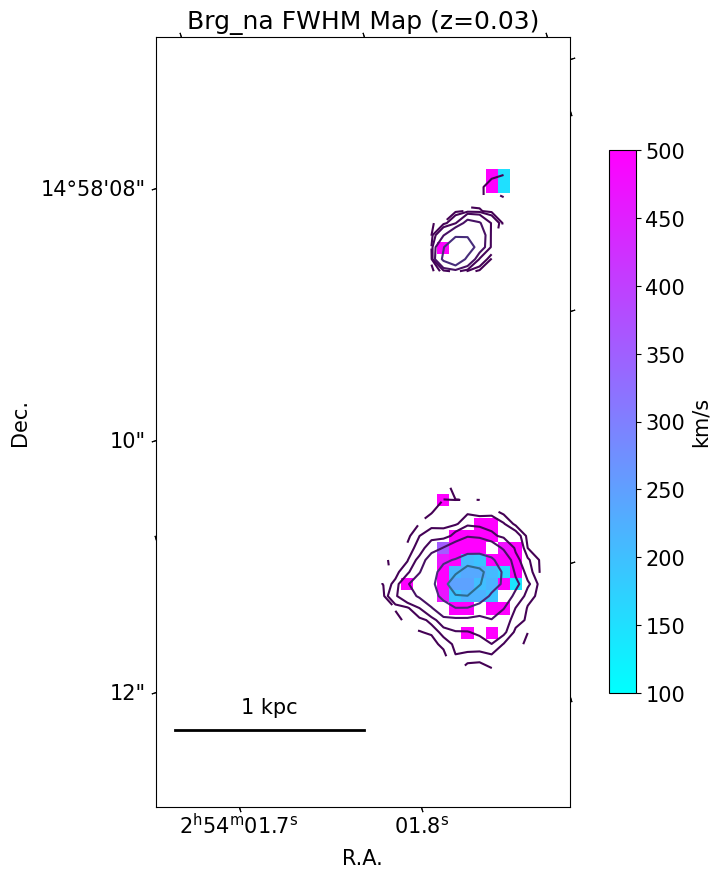

In [44]:
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux)
#mask=Lya_mflux < 2.*Lya_msig.value
#plotlw=line_shift_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (0, 20*std),cmap = "binary")
im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
vmin=100
vmax=500

ax.contour(masked_data*efactor,levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))

im = ax.imshow(line_value_array,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

cb = plt.colorbar(im, label = "km/s", fraction =0.035)

#Source position
#psname=sourcename


#for i in range(3):
#    sc = SkyCoord(ra=RA[i], dec=Dec[i], unit='deg',frame="icrs", equinox='J2000')
#    s_coord=wcsinfo.world_to_pixel(sc)
#    ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)


#-------------------Reference scale setting----------------#
dT = 1  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(z).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"{} FWHM Map (z={})".format(line,round(z,2)))
fig.savefig(datapath+f"/field_scan_osiris/line_property_map_{line}.pdf")

### Try to realign the OSIRIS WCS

INFO: Query finished. [astroquery.utils.tap.core]


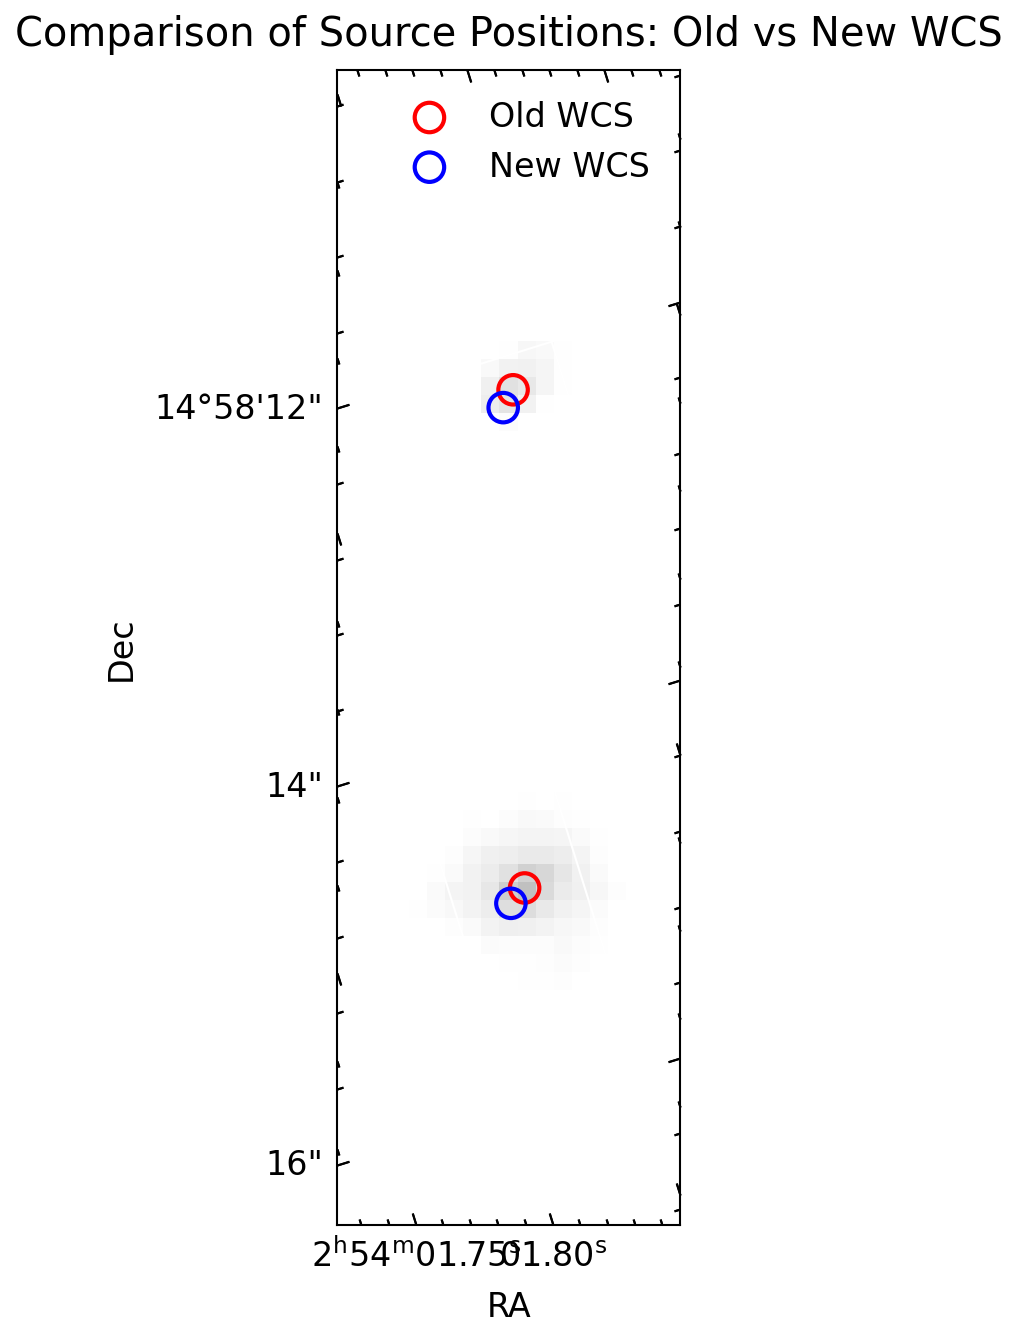

In [161]:
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS
from photutils.detection import DAOStarFinder
from photutils.segmentation import detect_sources,SourceCatalog,detect_threshold,deblend_sources
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs.utils import fit_wcs_from_points
import scienceplots
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

wcslist_new=[]
# Identify sources in the image

#for tempind,data in enumerate(imagelist[-2:]):
tempind=1
data=masked_data
old_wcs=wcsinfo
mean, median, std = sigma_clipped_stats(data,maxiters=None)
daofind = DAOStarFinder(fwhm=3.0, threshold=2.*std)
sources = daofind(data - median)
#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

catalog = SkyCoord.from_pixel(positions[:,0], positions[:,1], wcs=old_wcs)

# Query Gaia or SDSS catalog
# For Gaia:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"  # Specify the Gaia catalog version
radius = 0.005 * u.deg  # Adjust as necessary
center = catalog[0]  # Using the first source as the center, adjust as necessary

result = Gaia.query_object_async(coordinate=center, radius=radius)
gaia_coords = SkyCoord(result['ra'], result['dec'], unit='deg')


# Cross-match sources
idx, d2d, _ = gaia_coords.match_to_catalog_sky(catalog)

# Filter matches by a tolerance
tol = 21 * u.arcsec  # Adjust as necessary
matches = d2d < tol
matched_catalog = catalog[idx[matches]]
matched_gaia = gaia_coords[matches]

# Compute the WCS transformation
from astropy.wcs.utils import fit_wcs_from_points


#matchedra=matched_gaia.ra
#matcheddec=matched_gaia.dec
#xp=positions[idx[matches]][:,0]
#yp=positions[idx[matches]][:,1]

matchedra=matched_gaia.ra
matcheddec=matched_gaia.dec

xp=positions[:,0]
yp=positions[:,1]

new_sky_coords = SkyCoord(ra=[matchedra[0],matchedra[2]],dec=[matcheddec[0],matcheddec[2]],unit=u.deg)

#old_wcs.wcs.pc = [[ 0.95476078,  0.29737492],[0.29737492, -0.95476078]]
#old_wcs.wcs.crval=[matchedra[0].value, matcheddec[0].value]
#old_wcs.wcs.crpix=[xp[0],yp[0]]
#new_wcs = fit_wcs_from_points((xp,yp), new_sky_coords, projection='TAN')
#wcslist_new.append(new_wcs)

old_pixel_coords = np.transpose((sources['xcentroid'], sources['ycentroid']))
old_sky_coords = SkyCoord.from_pixel(old_pixel_coords[:,0], old_pixel_coords[:,1], wcs=old_wcs)

# Transform positions using new WCS
#new_sky_coords = SkyCoord.from_pixel(old_pixel_coords[:,0], old_pixel_coords[:,1], wcs=new_wcs)
# Plot the positions
plt.figure(figsize=(5, 5),dpi=300)
plt.subplot(projection=old_wcs)

norm = vis.ImageNormalize(vmin = std, vmax = med+10*std,stretch=vis.stretch.LogStretch())

plt.imshow(data, origin='lower', cmap='gray_r', norm=norm)
plt.scatter(old_pixel_coords[:, 0], old_pixel_coords[:, 1], s=50, edgecolor='red', facecolor='none', label='Old WCS')
plt.scatter(new_sky_coords.to_pixel(old_wcs)[0], new_sky_coords.to_pixel(old_wcs)[1], s=50, edgecolor='blue', facecolor='none', label='New WCS')

#plt.scatter(s_coord.to_pixel(old_wcs)[0],s_coord.to_pixel(old_wcs)[1],s=50, edgecolor='g', facecolor='none', label='QSO')
#plt.scatter(191,401,s=50, edgecolor='m', facecolor='none', label='fitted_QSO')

#from regions import RectangleSkyRegion
#center = s_coord
#region_sky4 = RectangleSkyRegion(center=center,
#                                 width=30. * u.arcsec, height=30. * u.arcsec,
#                                 angle=0.0 * u.deg)
#region_pix4 = region_sky4.to_pixel(old_wcs)
#ax=plt.gca()
#region_pix4.plot(origin=(0, 0),ax=ax,color="orange")
plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Comparison of Source Positions: Old vs New WCS')
plt.grid(color='white', ls='solid')

# Save the updated header to the second image
#hdu2.header.update(new_wcs2.to_header())


### Calculate hydrogen  mass from PyQSOFit result


In [315]:
ld

<Quantity 142.67198603 Mpc>

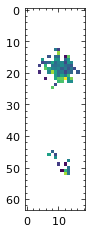

In [309]:
plt.imshow(A22map)

nan

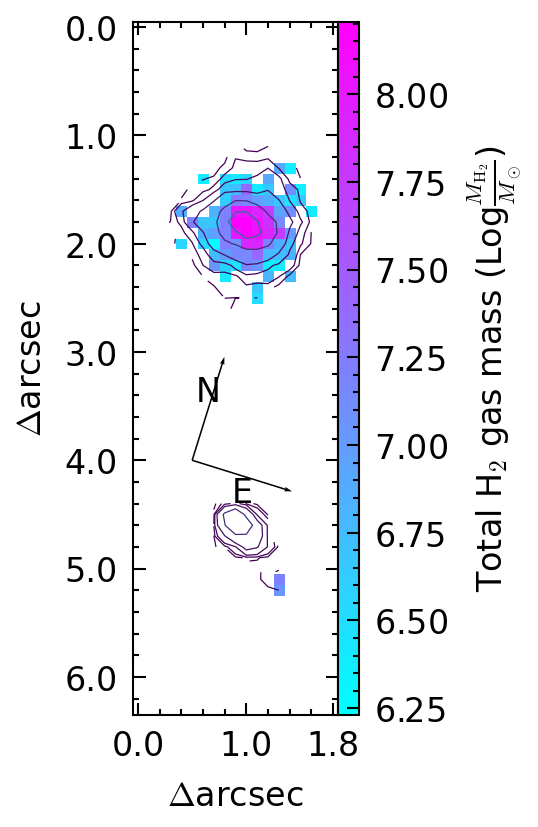

In [313]:

from dust_attenuation.averages import C00
Cex=C00()
#wave=[0.4821,0.5009,0.6563,2.12,2.2,]
EBV=0.88#3.1540189184745593
#hot2cold=7e-5
hot2cold=1/1.6e6 # Mazzalay+2013, aa37092-19
ld=Planck18.luminosity_distance(0.03145)
A22map=Cex.k_lambda(x=[2.199])*EBV_map
A22=Cex.k_lambda(x=[2.199])*EBV

efactor=1
line_toplot=np.full(sshape,fill_value=np.nan)
line="H2_10_S1"
for i in range(sshape[0]):
    for j in range(sshape[1]):
        if mask_2d_filtered[i,j]:
            line_toplot[i][j]=all_area[i][j][line]
            
            

MH2=5.1e13*(ld.to(u.Mpc).value)**2*(line_toplot*efactor*1e-17)*10**(0.4*A22)/hot2cold # cold H2 mass; Scoville+1982, Wolniewicz+1998
#logMHG=np.log10(MH2)+0.92
#MH=10**logMHG+MH2
pixscale=wcsinfo.wcs.cdelt[0]*3600
xmax=MH2.shape[1]
ymax=MH2.shape[0]

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

z_toplot=np.log10(MH2)

fig, ax, im1 = imshow_astro(z_toplot, cblabel = r"Total H$_{2}$ gas mass (Log$\frac{M_\mathrm{H_{2}}}{M_\odot}$)", colorbar=True,stretch=vis.LinearStretch(),figsize=(2,3), vrange = (np.nanmin(z_toplot), np.nanmax(z_toplot)),cmap = "cool")
                            #,extent=[-xmax*pix_scale/2, xmax*pix_scale/2, -ymax*pix_scale/2, ymax*pix_scale/2] )
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
ax.contour(masked_data*efactor,linewidths=0.3,levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))

x0, y0 = 5, 40
arrow_length = 1/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra + arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax.quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='k', ha='center', va='bottom')

# Plot the East arrow
ax.quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + east_vector[0]/2, y0 + east_vector[1]/2, 'E', color='k', ha='center', va='top')
#ax.text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")
yticks=np.array([0,10,20,30,40,50,60])
xticks=np.array([0,10,18])
ax.set_yticks(yticks)
ax.set_yticklabels(yticks*0.1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*0.1)
fig.savefig(datapath+"/fig/OSIRIS_H2mass.pdf")

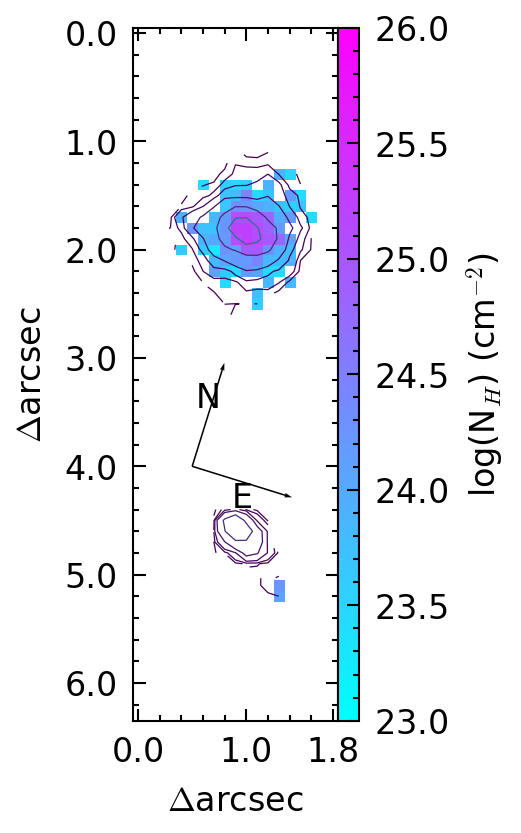

In [267]:
logMHG=np.log10(MH2)+0.92

pdis=Planck18.kpc_proper_per_arcmin(0.03145).to(u.cm/u.arcsec)
parea=(pixscale*u.arcsec*pdis)**2
NH_mol=constants.M_sun.to(u.g)*MH2/(2.01568*u.g/u.mole)*constants.N_A/parea*2

NH = np.log10((constants.M_sun.to(u.g)*10**logMHG/(1.00784*u.g/u.mole)*constants.N_A/parea+NH_mol).value)

NH[NH<20]=np.nan

z_toplot=NH

fig, ax, im1 = imshow_astro(z_toplot, cblabel = r"log(N$_{H}$) (cm$^{-2}$)", colorbar=True,stretch=vis.LinearStretch(),figsize=(2,3), vrange = (23, 26),cmap = "cool")
                            #,extent=[-xmax*pix_scale/2, xmax*pix_scale/2, -ymax*pix_scale/2, ymax*pix_scale/2] )
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
ax.contour(masked_data*efactor,linewidths=0.3,levels=np.logspace(np.log10(np.nanmin(masked_data*efactor)),np.log10(np.nanmax(masked_data*efactor)),8))

x0, y0 = 5, 40
arrow_length = 1/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra + arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax.quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='k', ha='center', va='bottom')

# Plot the East arrow
ax.quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + east_vector[0]/2, y0 + east_vector[1]/2, 'E', color='k', ha='center', va='top')
#ax.text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")
yticks=np.array([0,10,20,30,40,50,60])
xticks=np.array([0,10,18])
ax.set_yticks(yticks)
ax.set_yticklabels(yticks*0.1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*0.1)
fig.savefig(datapath+"/fig/OSIRIS_NHmap.pdf")

### Calculate ionized hydrogen mass from PyQSOFit result

In [87]:
image_reprojected, footprint = reproject_interp((MHII, wcsinfo), wcslist[0], shape_out=imagelist[0].shape)

array([[ 0.09547615,  0.02973752],
       [ 0.02973752, -0.09547615]])

In [179]:
MHII.shape

(64, 19)

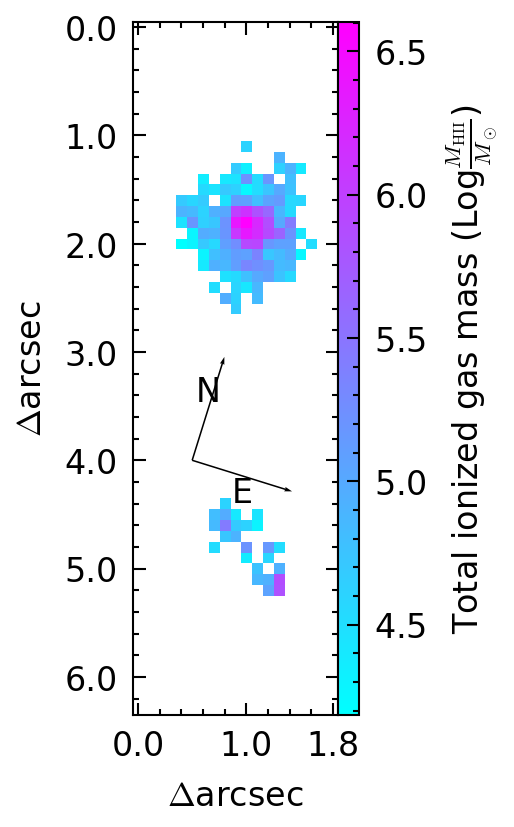

In [239]:
from dust_attenuation.averages import C00
Cex=C00()
#wave=[0.4821,0.5009,0.6563,2.12,2.2,]
EBV=3.1540189184745593
#hot2cold=7e-5
hot2cold=1/0.3e6 # Mazzalay+2013, aa37092-19
ld=Planck18.luminosity_distance(0.03145)
A22=Cex.k_lambda(x=[2.199])*EBV

line_toplot=np.full(sshape,fill_value=np.nan)
line="Brg_na"
for i in range(sshape[0]):
    for j in range(sshape[1]):
        if mask_2d_filtered[i,j]:
            line_toplot[i][j]=all_area[i][j][line]
            
efactor=1
ne=1e2
MHII=2.9e19*(ld.to(u.Mpc).value)**2*(line_toplot*efactor*1e-17)*10**(0.4*A22)/ne # cold H2 mass; Scoville+1982, Wolniewicz+1998
#MHG=
pixscale=wcsinfo.wcs.cdelt[0]*3600
xmax=MHII.shape[1]
ymax=MHII.shape[0]

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

z_toplot=np.log10(MHII)

fig, ax, im1 = imshow_astro(z_toplot, cblabel = r"Total ionized gas mass (Log$\frac{M_\mathrm{HII}}{M_\odot}$)", colorbar=True,stretch=vis.LinearStretch(),figsize=(2,3), vrange = (np.nanmin(z_toplot), np.nanmax(z_toplot)),cmap = "cool")
                            #,extent=[-xmax*pix_scale/2, xmax*pix_scale/2, -ymax*pix_scale/2, ymax*pix_scale/2] )
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")

x0, y0 = 5, 40
arrow_length = 1/3600

# Convert pixel coordinates to sky coordinates (RA, Dec)
sky_coords = wcsinfo.pixel_to_world(x0, y0)
ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

# Define the end points of the arrows in pixel coordinates
north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
east_end = wcsinfo.world_to_pixel_values(ra + arrow_length, dec)


# Calculate the direction vectors for the arrows
north_vector = [north_end[0] - x0, north_end[1] - y0]
east_vector = [east_end[0] - x0, east_end[1] - y0]

# Plot the North arrow
ax.quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='k', ha='center', va='bottom')

# Plot the East arrow
ax.quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.text(x0 + east_vector[0]/2, y0 + east_vector[1]/2, 'E', color='k', ha='center', va='top')
#ax.text(0.1,0.9,"{}".format(inst),transform=ax[0].transAxes,color="w")
yticks=np.array([0,10,20,30,40,50,60])
xticks=np.array([0,10,18])
ax.set_yticks(yticks)
ax.set_yticklabels(yticks*0.1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*0.1)

fig.savefig(datapath+"/fig/OSIRIS_HIImass.pdf")

In [210]:
sky_coords

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (43.50745576, 14.97083471)>

## Test

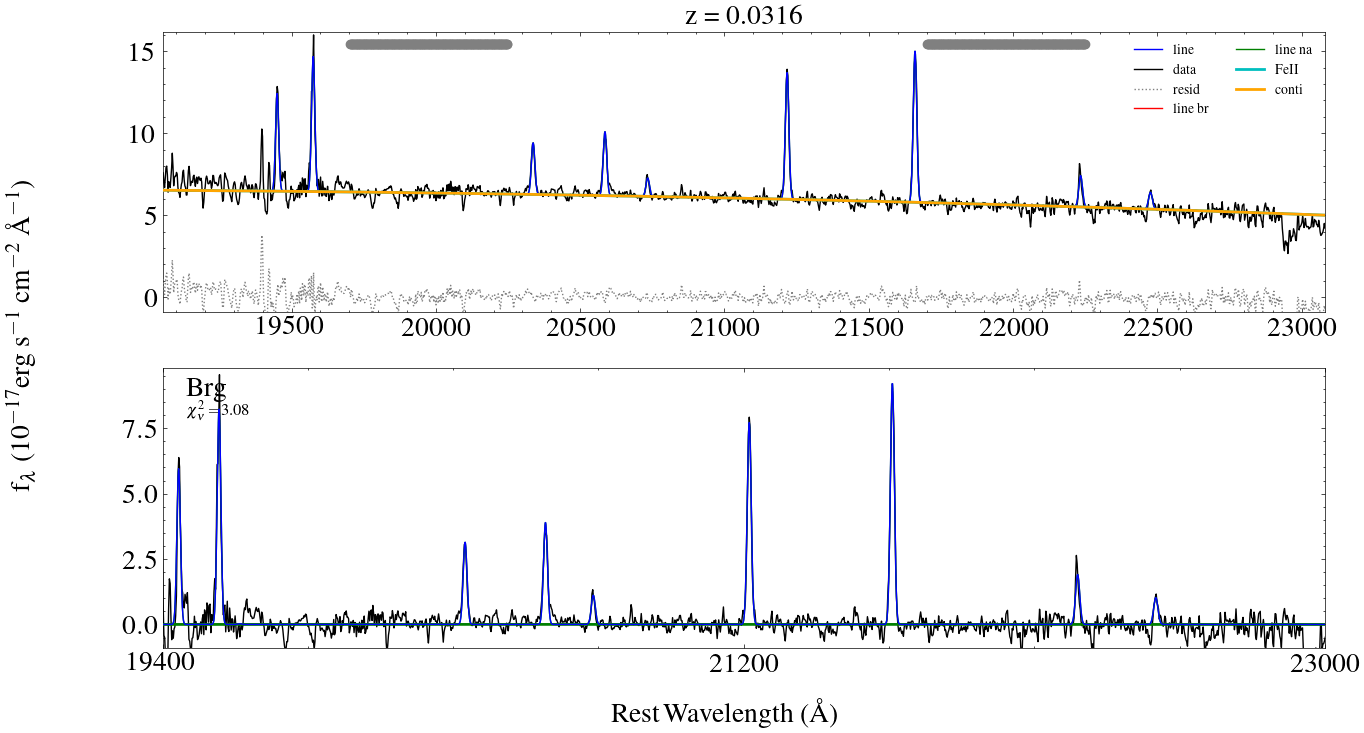

In [554]:
q_temp = QSOFit(s.wave*10, spec1, np.sqrt(var1), s.redshift, path=path_ex)

q_temp.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
      # prepocessing parameters
      nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
      and_mask=False,  # delete the and masked pixels
      or_mask=False,  # delete the or masked pixels
      reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
      deredden=True,  # correct the Galactic extinction
      wave_range=None,  # trim input wavelength
      wave_mask=None,  # 2-D array, mask the given range(s)

      # host decomposition parameters
      decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
      host_prior=False, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
      host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

      host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
      decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
      qso_type='CZBIN1', # PCA template name for quasar
      npca_qso=10, # numebr of quasar templates
      host_type='PCA', # template name for galaxy
      npca_gal=5, # number of galaxy templates

      # continuum model fit parameters
      Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
      poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
      BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
      initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
      rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
      n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

      # emission line fit parameters
      linefit=True,  # If True, the emission line will be fitted
      rej_abs_line=False,
      # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

      # fitting method selection
      MC=False,
      # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
      MCMC=False,
      # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
      nsamp=200,
      # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

      # advanced fitting parameters
      param_file_name='qsopar_field_OSIRIS_K_br.fits',  # Name of the qso fitting parameter FITS file.
      nburn=20,  # The number of burn-in samples to run MCMC chain
      nthin=10,  # To set the MCMC chain returns every n samples
      epsilon_jitter=0.,
      # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

      # customize the results
      save_result=False,  # If True, all the fitting results will be saved to a fits file
      save_fits_name=None,  # The output name of the result fits
      save_fits_path=path_out,  # The output path of the result fits
      plot_fig=True,  # If True, the fitting results will be plotted
      save_fig=False,  # If True, the figure will be saved
      plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True

      # debugging mode
      verbose=False,  # turn on (True) or off (False) debugging output

      # sublevel parameters for figure plot and emcee
      kwargs_plot={
          'save_fig_path': '.',  # The output path of the figure
          'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
      },
      kwargs_conti_emcee={},
      kwargs_line_emcee={})

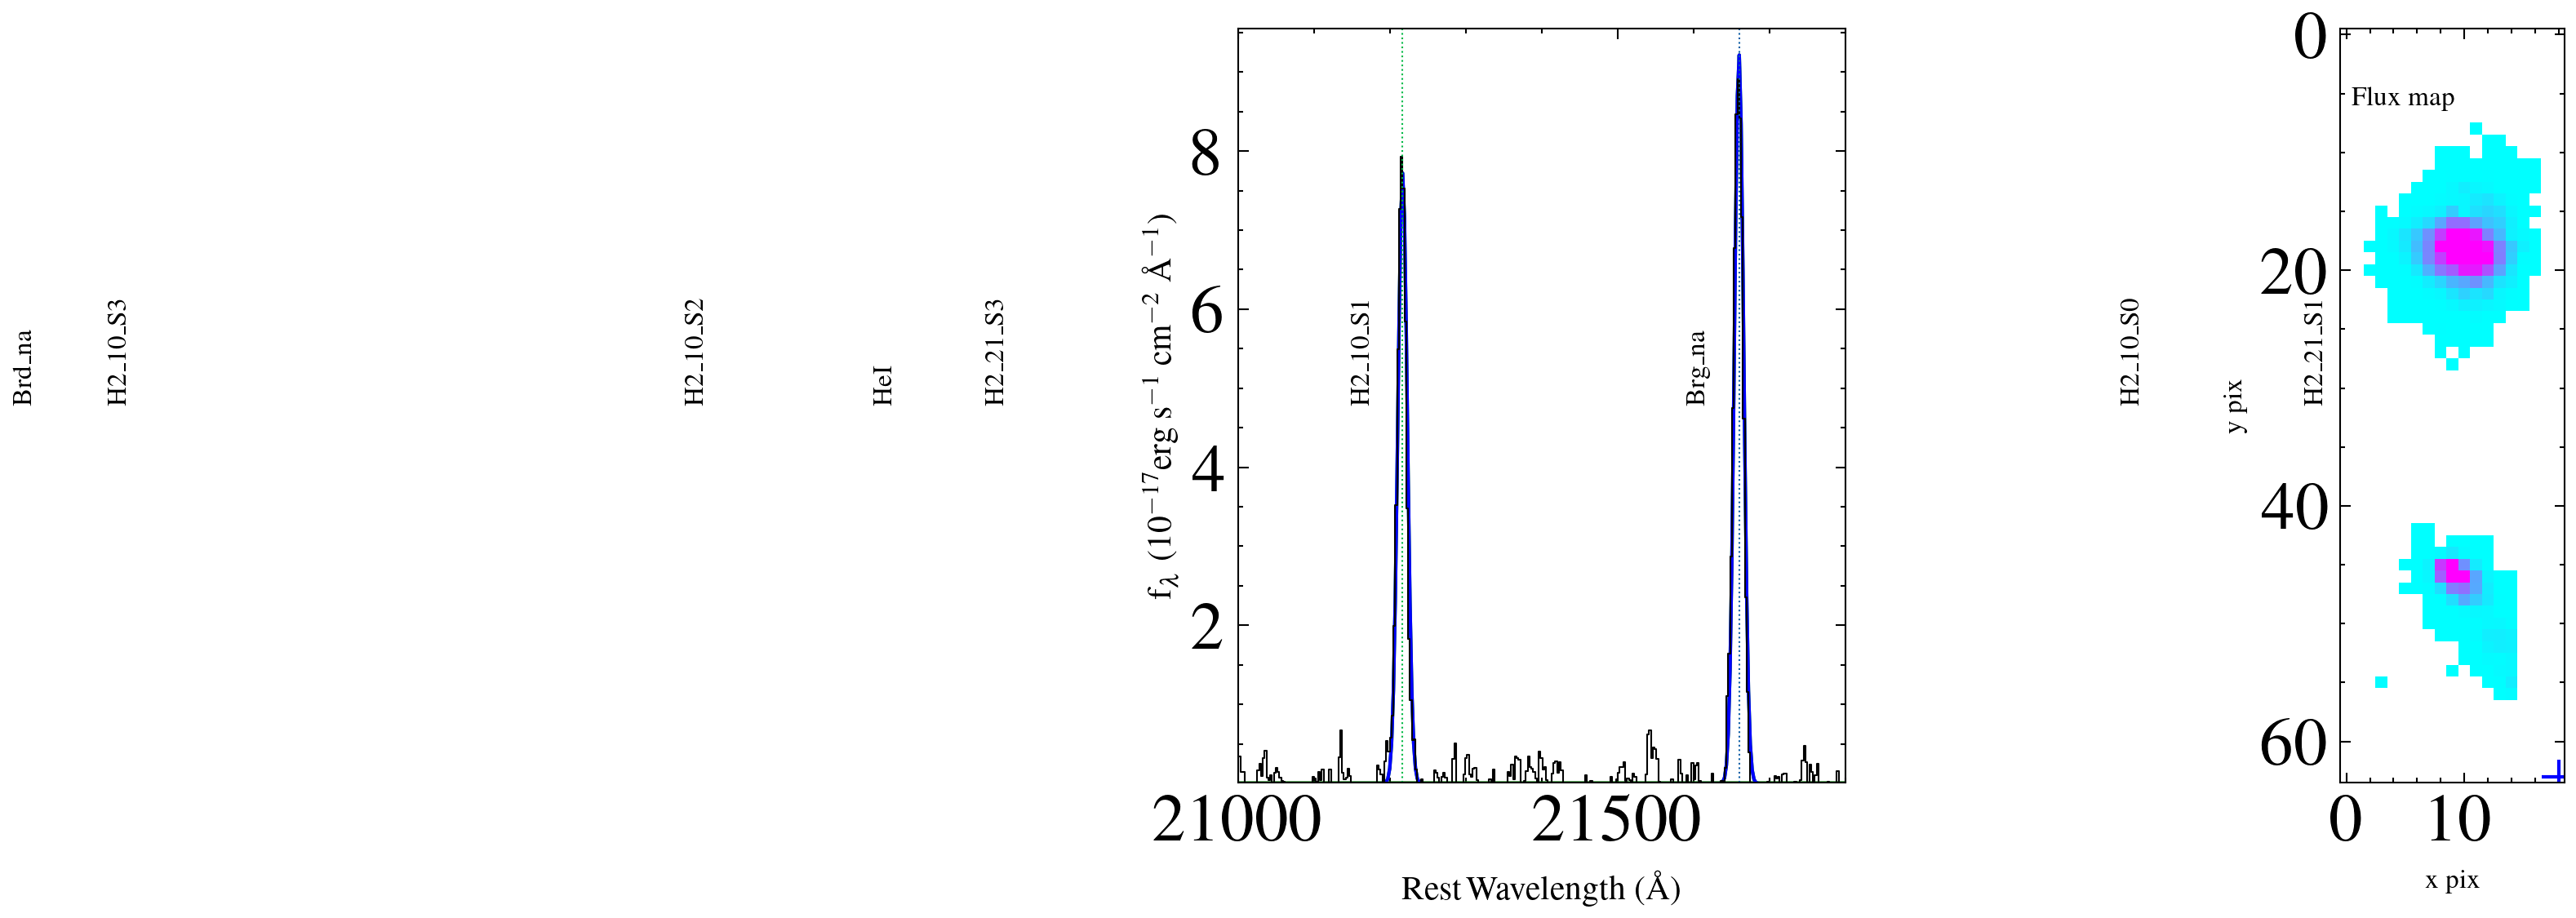

In [557]:
q=q_temp
plot=True
if plot:
    fig, axs = plt.subplots(1, 2,figsize=(8,4), dpi=300)
    plt.subplots_adjust(wspace=0.5)
    ax=axs[0] 
#q=q_mle

#q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)

if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result
#plt.subplot(111)

# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    if plot:
        ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)
if plot:
    # Plot total line model
    ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
    ax.step(q.wave, q.line_flux, 'k',lw=0.5)
    yup=np.max(q.line_flux)
    #ax.step(q.wave,q.err)
    ax.set_xlim(21000, 21800)
    ax.set_ylim(1e-2, yup)
areas={}
peaks={}
fwhms={}
snrs={}
for ind,ln in enumerate(ln_to_print):
    try:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'narrow')
    except:
        snr=0
    if snr > 0.1:
        areas[ln]=area
        fwhms[ln]=fwhm
        peaks[ln]=peak
        snrs[ln]=snr
    else:
        areas[ln]=None
        fwhms[ln]=None
        peaks[ln]=peak
        snrs[ln]=snr
    if plot:
        ax.axvline(peak,color="C{}".format(ind),lw=0.5,ls=":")
        ax.text(peak*0.9975, 5e-1*yup,ln, rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)

#ax.set_yscale("log")
if plot:
    ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
    ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)
#plt.subplot(122)
#
    ax=axs[1]
    #mag=-2.5*np.log10(signal/np.sum(signal).ravel())
    #levels=[8,9,10,13,15,18,20,25,30,35,40]
    #img=display_bins(s.x, s.y, bin_num, np.array(line_properties[line+"_vpec"]),vmin=-100,vmax=350 ,cmap="viridis",colorbar=1,pixelsize=s.pixelsize, label=r'$V_{shift}$ (km/s)')
    img = ax.imshow(masked_data,cmap=cmap,alpha=alpha,vmin=std,vmax=30*std)#,norm=norm)

    #ax=plt.gca()
    ax.set_xlabel(r"x pix")
    ax.set_ylabel(r"y pix")
    #RApix=[3.4,4.4,5.3]
    #Decpix=[1.8,4.4,3.]
    #for io in range(3):
    #    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
    #ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
    ax.text(0.05,0.9,"Flux map",color="k",transform=ax.transAxes)
    ax.plot(j, i,"+",c="b",ms=10,lw=0.01)


In [558]:
fwhms["Brg_na"]

202.39551719940746

In [561]:
areas["H2_10_S1"]/areas["Brg_na"]

0.8509810269276021

In [566]:
q.line_prop_from_name("Brg_br", 'narrow')

(1304.2417273094243,
 533.5724468897632,
 0.10451659855894402,
 21933.526007001285,
 0.5930237865738489,
 0.06472273348966587)